In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()

    train_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(tqdm(dataloader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    avg_train_loss = train_loss / len(dataloader)
    train_accuracy = correct / total
    return avg_train_loss, train_accuracy


def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item()
            total_samples += inputs.size(0)
            y_true += labels.tolist()
            y_pred += preds.tolist()
            
    loss = running_loss / total_samples
    accuracy = running_corrects / total_samples
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    return loss, accuracy, f1, cm

### Alexnet model

In [4]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

### load data and create data_loader

In [17]:
# Load the data from files
X = np.load('aug_img.npy')
y = np.load('aug_lbl.npy')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

# Create TensorDataset objects for train and test sets
train_dataset = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train))
valid_dataset = TensorDataset(torch.tensor(X_valid).float(), torch.tensor(y_valid))
test_dataset = TensorDataset(torch.tensor(X_test).float(), torch.tensor(y_test))

# Create DataLoader objects for train and test sets
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
print(X_train.shape)

(777, 3, 240, 240)


In [19]:
print(X_valid.shape)

(97, 3, 240, 240)


In [20]:
print(X_test.shape)

(98, 3, 240, 240)


### Train model

In [22]:
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AlexNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5)

best_loss = float('inf')
patience = 3
threshold = 0.4
counter = 0

tr_loss_hist, tr_acc_hist = [], []
val_loss_hist, val_acc_hist = [], []
test_loss_hist, test_acc_hist = [], []

for epoch in range(32):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _ = evaluate(model, valid_loader, criterion, device)
    test_loss, test_acc, _, _ = evaluate(model, test_loader, criterion, device)

    tr_loss_hist.append(train_loss)
    tr_acc_hist.append(train_acc)
    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)
    test_loss_hist.append(test_loss)
    test_acc_hist.append(test_acc_hist)
    
    print(f'Epoch {epoch+1}: TrLoss: {train_loss:.4f}, TrAcc: {train_acc:.4f} - ValLoss: {val_loss:.4f}, ValAcc: {val_acc:.4f} - TestLoss: {test_loss:.4f}, TestAcc: {test_acc:.4f}')

    # early stopping
    if val_loss < best_loss and val_loss > threshold:
        best_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter == patience:
            print(f'Validation loss did not improve for {patience} epochs. Early stopping...')
            break
        if  val_loss <= threshold:
            print(f'Validation loss crossed defined threshold {threshold}. Early stopping...')
            break
            
test_loss, test_acc, test_f1, test_cm = evaluate(model, test_loader, criterion, device)

100%|███████████████████████████████████████████| 98/98 [03:28<00:00,  2.13s/it]


Epoch 1: TrLoss: 0.6924, TrAcc: 0.5135 - ValLoss: 0.6979, ValAcc: 0.5052 - TestLoss: 0.6999, TestAcc: 0.5000


100%|███████████████████████████████████████████| 98/98 [02:57<00:00,  1.81s/it]


Epoch 2: TrLoss: 0.6757, TrAcc: 0.5611 - ValLoss: 0.6690, ValAcc: 0.6082 - TestLoss: 0.6785, TestAcc: 0.5816


100%|███████████████████████████████████████████| 98/98 [02:50<00:00,  1.74s/it]


Epoch 3: TrLoss: 0.6510, TrAcc: 0.6512 - ValLoss: 0.5915, ValAcc: 0.7526 - TestLoss: 0.6127, TestAcc: 0.7245


100%|███████████████████████████████████████████| 98/98 [02:55<00:00,  1.79s/it]


Epoch 4: TrLoss: 0.5676, TrAcc: 0.7079 - ValLoss: 0.4463, ValAcc: 0.8454 - TestLoss: 0.4731, TestAcc: 0.8163


100%|███████████████████████████████████████████| 98/98 [03:19<00:00,  2.04s/it]


Epoch 5: TrLoss: 0.3676, TrAcc: 0.8378 - ValLoss: 0.6660, ValAcc: 0.6392 - TestLoss: 0.6700, TestAcc: 0.6224


100%|███████████████████████████████████████████| 98/98 [03:00<00:00,  1.85s/it]


Epoch 6: TrLoss: 0.2161, TrAcc: 0.9266 - ValLoss: 0.2383, ValAcc: 0.8969 - TestLoss: 0.3162, TestAcc: 0.8776
Validation loss crossed defined threshold 0.4. Early stopping...


### Show num params

In [7]:
num_params = torch.numel(torch.nn.utils.parameters_to_vector(model.parameters()))

In [8]:
print(num_params)

57012034


### Confusion matrix

Test Loss: 0.3162, Test Accuracy: 0.8776 - f1_score: 0.8605


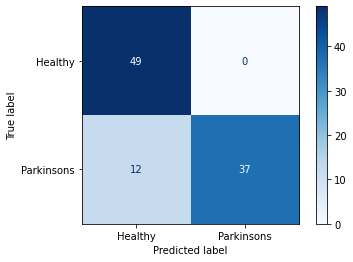

In [23]:
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f} - f1_score: {test_f1:.4f}')
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=['Healthy','Parkinsons'])

disp.plot(cmap="Blues");

In [ ]:
# Label 1 (Parkinson)
# precision 1.00 -> 100
# recall .76 -> 76

# Label 2 (Healthy)
# precision .80 -> 80
# recall 1.00 -> 100

# Average Precision (1+.8)/2 = 0.9
# Average Recall (.76+1)/2 = 0.88

### Plot loss curve for train, valid, test

In [1]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(tr_loss_hist, label='Training Loss')
plt.plot(val_loss_hist, label='Validation Loss')
plt.plot(test_loss_hist, label='Test Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(tr_acc_hist, label='Training Accuracy')
plt.plot(val_acc_hist, label='Validation Accuracy')
plt.plot(test_acc_hist, label='Test Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()